In [1]:
import faiss
import numpy as np
import time
#import faiss.contrib.torch_utils
import torch
import pandas as pd 

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

df = pd.read_pickle('DATA/Dataset/wikiart_full_combined_try.pkl')
unique_values = df['artist_name'].explode().unique()
df['influenced_by'] = df['influenced_by'].apply(lambda x: [i for i in x if i in unique_values])
df = df[df['influenced_by'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
feature = 'image_features'

tensors = torch.stack(df[feature].tolist()).to(device)
tensor_dim = tensors.shape[1]
nb_tensors = tensors.shape[0]
k = 11

query_tensors = tensors.cpu().numpy()
nlist = 100  # adjust based on experimentation
quantizer = faiss.IndexFlatL2(tensor_dim)
index = faiss.IndexIVFFlat(quantizer, tensor_dim, nlist)
#index = faiss.index_cpu_to_all_gpus(index)  # If you're using multiple GPUs
index.train(tensors.cpu().numpy())
index.add(tensors.cpu().numpy())



# Perform search
start_time = time.time()
D, I = index.search(query_tensors, k)
end_time = time.time()
print("Standard search time: {:.4f} seconds".format(end_time - start_time))

df['index_vector_similarity'] = I.tolist()


Standard search time: 0.5812 seconds


Treat the problem as an Information Retrieval task

In [49]:
import faiss
import numpy as np
import time
import torch
import pandas as pd 
import random

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
df = pd.read_pickle('DATA/Dataset/wikiart_full_combined_try.pkl')
unique_values = df['artist_name'].explode().unique()
df['influenced_by'] = df['influenced_by'].apply(lambda x: [i for i in x if i in unique_values])
df = df[df['influenced_by'].apply(lambda x: len(x) > 0)].reset_index(drop=True)

In [60]:
from Triplet_Network import TripletResNet_features
import torch.nn as nn

model = TripletResNet_features(df.loc[0,feature].shape[0])
model_path ='trained_models/TripletResNet_image_features_posfaiss_negfaiss.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()
feature = 'image_features'
df[f'trained_{feature}'] = df[feature].apply(lambda x: model.forward_once(x).detach())

/Users/traopia/miniconda3/envs/artsagenet_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [65]:

class Evaluation():
    def __init__(self,df,feature,num_examples,device):
        self.df = df
        self.feature = feature
        self.num_examples = num_examples
        self.device = device
        self.dict_influence_indexes, self.artist_to_paintings, self.dict_influenced_by = self.get_dictionaries(df)

    def mean_reciprocal_rank(self,ground_truth, ranked_lists):
        """
        Compute the Mean Reciprocal Rank (MRR) for a set of queries.
        
        Parameters:
            ground_truth (dict): Dictionary where keys are query IDs and values are lists of relevant document IDs.
            ranked_lists (dict): Dictionary where keys are query IDs and values are ranked lists of document IDs.
            
        Returns:
            float: Mean Reciprocal Rank (MRR) value.
        """
        total_rr = 0.0
        num_queries = len(ground_truth)
        
        for query_id, relevant_docs in ground_truth.items():
            if query_id in ranked_lists:
                ranked_list = ranked_lists[query_id]
                reciprocal_rank = 0.0
                for i, doc_id in enumerate(ranked_list, start=1):
                    if doc_id in relevant_docs:
                        reciprocal_rank = 1.0 / i
                        break
                total_rr += reciprocal_rank
        
        if num_queries > 0:
            return total_rr / num_queries
        else:
            return 0.0  # Return 0 if there are no queries
        
    def get_dictionaries(self,df):
        dict_influenced_by = df.groupby('artist_name')['influenced_by'].first().to_dict()
        artist_to_paintings = {}
        for index, row in df.iterrows():
            artist = row['artist_name']
            artist_to_paintings.setdefault(artist, []).append(index)
        artist_to_influencer_paintings = {artist: [painting for influencer in influencers if influencer in artist_to_paintings for painting in artist_to_paintings[influencer]] for artist, influencers in dict_influenced_by.items()}
        keys_min_val = [key for key, value in artist_to_influencer_paintings.items() if isinstance(value, list) and len(value) > self.num_examples]
        artist_to_influencer_paintings = {key: value for key, value in artist_to_influencer_paintings.items() if key in keys_min_val}
        artisit_no_influencers = [k for k, v in artist_to_influencer_paintings.items() if len(v) == 0]
        artist_to_influencer_paintings = {key: value for key, value in artist_to_influencer_paintings.items() if key not in artisit_no_influencers}
        artist_to_paintings_new = {key: value for key, value in artist_to_paintings.items() if key in artist_to_influencer_paintings.keys()}
        dict_influenced_by = {key: value for key, value in dict_influenced_by.items() if key in artist_to_influencer_paintings.keys()}

        return artist_to_influencer_paintings, artist_to_paintings_new, dict_influenced_by

    def vector_similarity_search_group(self,query_indexes, index_list,df):
        '''Search for similar vectors in the dataset using faiss library'''
        k = self.num_examples + 1
        index_list = [i for i in index_list if i < len(self.df)]
        if index_list != None:
            xb = torch.stack(df[self.feature].tolist())[index_list]
        else:
            xb = torch.stack(df[self.feature].tolist())
        d = xb.shape[1]
        index = faiss.IndexFlatL2(d)
        if xb.shape[0] < 1000:
            index = faiss.IndexFlatL2(d)
        else:
            nlist = 10  
            quantizer = faiss.IndexFlatL2(d)
            index = faiss.IndexIVFFlat(quantizer, d, nlist)
        
        if self.device == 'cuda':
            index = faiss.index_cpu_to_all_gpus(index)
            
        index.train(xb.cpu().numpy() if self.device != 'cuda' else xb)
        index.add(xb.cpu().numpy() if self.device != 'cuda' else xb)
        results = []
        for query in query_indexes:
            query_vector = self.df[self.feature].tolist()[query]
            D, I = index.search(query_vector.reshape(1,-1), k)  
            I = list(I[0][1:])   
            I = [index_list[i] for i in I]
            results.append(I)
            
        return results


    def positive_examples_group(self):
        search_among_influencers = False
        grouped = df.groupby('artist_name')
        self.df[f'pos_ex_{self.feature}'] = [None]*len(self.df)
        precision_at_k_artist, precision_at_k_artist_second_degree = {}, {}
        mrr_artist, mrr_artist_second_degree = {}, {}
        for artist, group in grouped:
            query = list(group.index)
            query = [i for i in query if i < len(self.df)]
            if artist in self.dict_influence_indexes:
                influencers_list = self.dict_influence_indexes[artist]
                artist_influencers = [j for j in self.dict_influenced_by[artist] if j in self.dict_influence_indexes.keys()]
                second_degree_influencers = [self.dict_influence_indexes[j] for j in artist_influencers]
                if len(second_degree_influencers) > 0:
                    second_degree_influencers = second_degree_influencers[0] + influencers_list
                else:
                    second_degree_influencers = influencers_list

                if search_among_influencers:
                    index_list = self.dict_influence_indexes[artist]
                    index_list = [i for i in index_list if i < len(self.df)]
                else:
                    no_index_list = self.artist_to_paintings[artist]
                    index_list = set(df.index) - set(no_index_list)

                if len(index_list) > 0:  # Check if index_list is not empty
                    results = self.vector_similarity_search_group(query, index_list, df)
                    precision_at_k, precision_at_k_second_degree = [], []
                    mrr_overall, mrr_overall_second_degree = [], []
                else:
                    results = []
                    precision_at_k, precision_at_k_second_degree = [], []
                    mrr_overall, mrr_overall_second_degree = [], []

                for i,q in enumerate(query):
                    self.df.at[q,f'pos_ex_{self.feature}'] = results[i]
                    influencers_in_results = [j for j in results[i] if j in influencers_list]
                    second_degree_influencers_in_results = [j for j in results[i] if j in second_degree_influencers]
                    mrr = self.mean_reciprocal_rank({q:influencers_list}, {q:results[i]})
                    mrr_second_degree = self.mean_reciprocal_rank({q:second_degree_influencers}, {q:results[i]})

                    precision_at_k.append(len(influencers_in_results)/self.num_examples)
                    mrr_overall.append(mrr)

                    precision_at_k_second_degree.append(len(second_degree_influencers_in_results)/self.num_examples)
                    mrr_overall_second_degree.append(mrr_second_degree)


                #influencers_right_artist = [len(i) for i in influencers_right_artist]
                print(f'For Artist {artist}, Influencers in results: {np.mean(precision_at_k)}, MRR: {np.mean(mrr_overall)}')
                print(f'For Artist {artist}, Second Degree Influencers in results: {np.mean(precision_at_k_second_degree)}, MRR: {np.mean(mrr_overall_second_degree)}')
                precision_at_k_artist[artist] = np.mean(precision_at_k)
                mrr_artist[artist] = np.mean(mrr_overall)
                precision_at_k_artist_second_degree[artist] = np.mean(precision_at_k_second_degree)
                mrr_artist_second_degree[artist] = np.mean(mrr_overall_second_degree)


        return df[f'pos_ex_{self.feature}'], precision_at_k_artist, mrr_artist, precision_at_k_artist_second_degree, mrr_artist_second_degree
    
retrieved_indexes, precision_at_k_artist, mrr_artist,precision_at_k_artist_second_degree, mrr_artist_second_degree = Evaluation(df,feature,10,device).positive_examples_group()

For Artist adriaen-brouwer, Influencers in results: 0.002325581395348837, MRR: 0.0033222591362126242
For Artist adriaen-brouwer, Second Degree Influencers in results: 0.04418604651162791, MRR: 0.16655592469545957
For Artist adriaen-van-ostade, Influencers in results: 0.008791208791208791, MRR: 0.020512820512820513
For Artist adriaen-van-ostade, Second Degree Influencers in results: 0.06703296703296703, MRR: 0.14000523286237573
For Artist albrecht-durer, Influencers in results: 0.02028985507246377, MRR: 0.04965253814891496
For Artist albrecht-durer, Second Degree Influencers in results: 0.10543478260869565, MRR: 0.21693457173529637
For Artist alfred-sisley, Influencers in results: 0.07161290322580645, MRR: 0.1493232633555214
For Artist alfred-sisley, Second Degree Influencers in results: 0.07161290322580645, MRR: 0.1493232633555214
For Artist alphonse-mucha, Influencers in results: 0.0014925373134328358, MRR: 0.005223880597014925
For Artist alphonse-mucha, Second Degree Influencers in r

In [58]:
np.mean(list(mrr_artist_second_degree.values()))

0.20519240598764377

In [63]:
np.mean(list(mrr_artist.values()))

0.08582745490791481

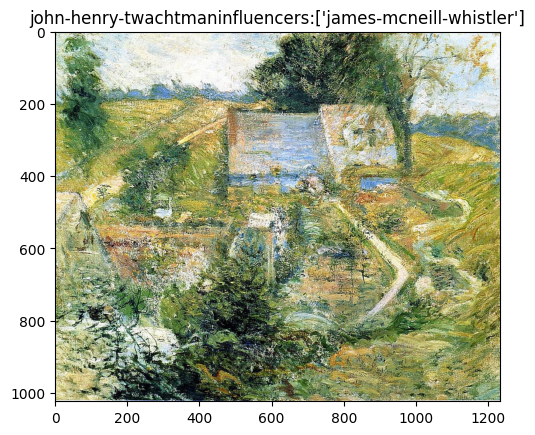

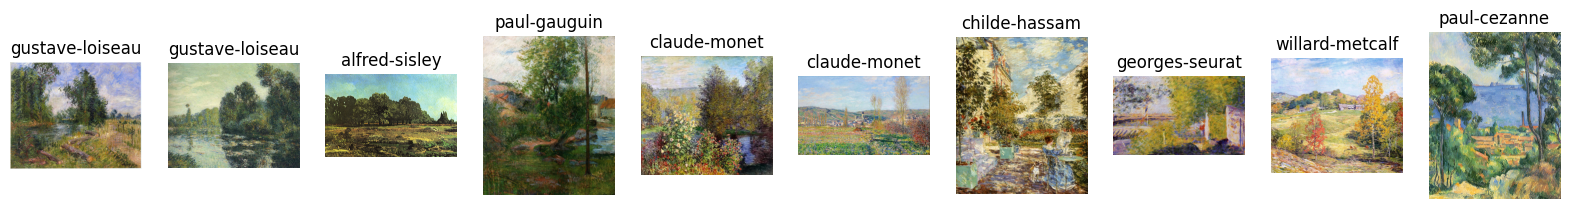

In [66]:
from matplotlib import pyplot as plt
from PIL import Image
def plot_examples(query, positive_indexes, df):
    plt.imshow(Image.open('wikiart/'+df.loc[query].relative_path))
    plt.title(str(df.loc[query].artist_name+ 'influencers:'+str(df.loc[query].influenced_by)))
    fig, axes = plt.subplots(1, 10, figsize=(20, 10))
    for i, ax in enumerate(axes):
        #ax.imshow(Image.open('wikiart/'+df.iloc[query].relative_path))
        image_path = 'wikiart/'+df.iloc[positive_indexes[i]].relative_path
        image =  Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(df.iloc[positive_indexes[i]].artist_name)

query = 999
plot_examples(query,retrieved_indexes[query],df)